In [ ]:
import sys
import torch
from stlkernel import kernel, formulae, trajectories, krr
import matplotlib.pyplot as plt

In [82]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [83]:
f0 = formulae.F0(n_vars=1)
mu0 = trajectories.Mu0(device=device)

In [84]:
def compute_expected_rho(formulae, trajectories):
    with torch.no_grad():
        y = torch.tensor([
            f.quantitative(trajectories, normalize=True).mean()
            for f in formulae
        ], device=device)
    return y

In [85]:
formulae_train = f0.sample(n_formulae=500)
formulae_test  = f0.sample(n_formulae=100)

In [95]:
for i in range(5):
    print(formulae_train[i],"\n")

eventually[0,5] ( ( always[0,2] ( always[0,5] ( x_0 >= 2.2058 ) ) and always[0,7] ( not ( not ( eventually[0,3] ( x_0 <= -1.1356 ) ) ) ) ) ) 

( x_0 <= 0.1948 or ( not ( x_0 <= -0.6967 ) or x_0 <= 0.8986 ) ) 

( ( ( x_0 <= 0.8146 until[0,8] x_0 >= -0.7557 ) until[0,9] ( x_0 >= 1.4041 and x_0 <= 1.4753 ) ) or ( not ( x_0 >= 0.4797 ) or always[0,6] ( always[0,7] ( x_0 <= -1.1135 ) ) ) ) 

not ( always[0,7] ( x_0 <= 0.9616 ) ) 

always[0,11] ( x_0 <= 0.9126 ) 



In [86]:
trajectory_sampler = lambda n: mu0.sample(n_trajectories=n, n_vars=1)

In [87]:
target_trajectories, time_steps = trajectory_sampler(100)
y_train = compute_expected_rho(formulae=formulae_train, trajectories=target_trajectories)
y_test  = compute_expected_rho(formulae=formulae_test, trajectories=target_trajectories)

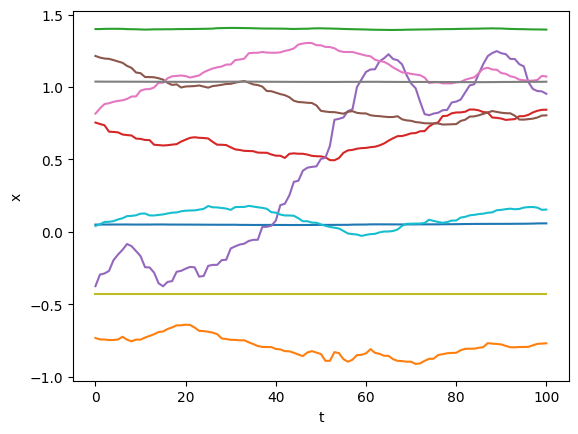

In [102]:
plt.plot(target_trajectories[:10].cpu().squeeze(1).T)
plt.xlabel("t")
plt.ylabel("x")
plt.show()

In [88]:
krr_model = krr.STLKernelRidgeRegression(
    trajectory_sampler=trajectory_sampler,
    alpha=0.01,
    kernel_type='gaussian',
    sigma=1.0,
    n_trajectories=1000,
    device=device,
    verbose=True,
)

In [89]:
krr_model.fit(formulae_train, y_train)
y_pred = krr_model.predict(formulae_test)

Fitting KRR with 500 training formulae...


K' matrix: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:51<00:00,  9.77it/s]


Training complete. Weights shape: torch.Size([500, 1])
Predicting for 100 test formulae...
Computing robustness matrices...


Computing robustness matrix: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 113.76it/s]


Computing test-train kernel matrix...


In [90]:
r2_score = krr_model.score(formulae_test, y_test)
print(f"R² score: {r2_score:.4f}")

mse = torch.mean((y_test - y_pred) ** 2)
print(f"MSE: {mse:.4f}")

Predicting for 100 test formulae...
Computing robustness matrices...


Computing robustness matrix: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 113.77it/s]


Computing test-train kernel matrix...
R² score: 0.9916
MSE: 0.0018


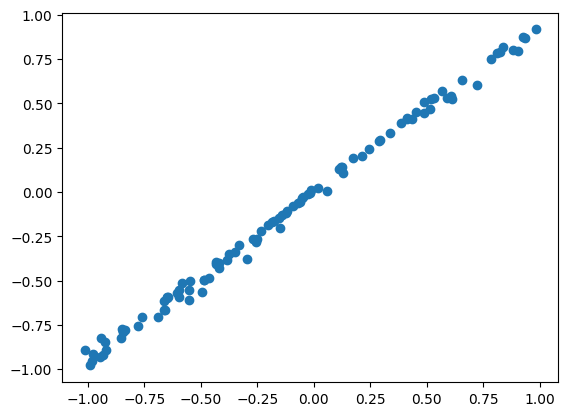

In [ ]:
plt.scatter(y_pred.cpu(), y_test.cpu())